This script checks if regulons have consistent expression.

The steps are the following:
* iterate over regulons.
* plot row expression.
* plot the log2 expression.
* scale the data. Consider z-scores and real scaling within a defined range.
* run PCA. Check how much variance is explained by PC1. This is the key to accept regulon tightness.
* use scores as values for heatmap.
* optionally, check the correlation of TF and PC1 to reveal if the TF is transcriptionally or posttranscriptionally regulated, e.g., phosphorylation.

In [1]:
import pandas, numpy

In [2]:
import scipy, scipy.stats
import sklearn, sklearn.decomposition

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(8, 4)})

In [4]:
import pyensembl
annotation = pyensembl.EnsemblRelease(86) # better matching than version 100
annotation

EnsemblRelease(release=86, species='homo_sapiens')

# 0. user-defined variables

In [5]:
regulon_input_file = '/home/adrian/projects/osteo/results/grn/regulons.txt'
expression_data_input_file = '/home/adrian/projects/osteo/results/tpm/DESeq2_TPM_values.tsv'
metadata_file = '/home/adrian/projects/osteo/metadata/MSC_Sample list.csv'
DETs_input_file = '/home/adrian/projects/osteo/results/DETs_filtered/entire_DET_set.txt'

In [6]:
donors = ['6', '16', '17']
days = ['Day_3', 'Day_6', 'Day_9', 'Day_16', 'Day_28']

# 1. read data

## 1.1. read regulon memberships

In [7]:
df = pandas.read_csv(regulon_input_file, sep='\t', index_col=0)
df.head()

,TF targets DEGs / all TF targets,background DEG rank / background TF targets rank,Targets fold-enrichment,Uncorrected hypergeometric P value,Adjusted P value (BH; alpha=0.1),Observed TF target DEGs
TF,,,,,,
KLF16,59/799,1089/20300,1.376491,8.068623e-03,7.106365e-02,"NECTIN1, DDIT4, PAFAH1B3, NOP2, PRKAR1B, CILP2..."
E2F8,186/740,1089/20300,4.685429,2.279433e-75,2.710246e-72,"NECTIN1, PDE1A, UHRF1, EXO1, SPC25, RRM2, BLM,..."
ZNF750,47/495,1089/20300,1.769949,1.095739e-04,1.714255e-03,"NECTIN1, DOCK10, ST3GAL5, MCC, NRCAM, MYO1B, M..."
HIVEP3,25/192,1089/20300,2.427208,3.699457e-05,6.283792e-04,"NECTIN1, UHRF1, NOP2, PPRC1, CILP2, QSOX2, IL1..."
GATA5,44/516,1089/20300,1.589539,1.676692e-03,1.812352e-02,"C1QTNF6, NCAPG, TNFRSF19, GNB3, EFEMP1, CFD, C..."


## 1.2. read expression data

In [8]:
def metadata_reader():

    metadata = {}
    donors = []
    days = []

    with open(metadata_file, 'r') as f:
        next(f)
        for line in f:
            v = line.split(',')
            sample = v[0]
            day = v[-2]
            donor = v[-3]
            metadata[sample] = (donor, day)

            if donor not in donors:
                donors.append(donor)
            if day not in days:
                days.append(day)

    return metadata, donors, days

In [9]:
metadata, donors, days = metadata_reader()
print(days)

['Day_3', 'Day_6', 'Day_9', 'Day_16', 'Day_28']


In [10]:
expression = {}
ensembl_IDs = []

for sample in metadata:
    expression[sample] = {}

with open(expression_data_input_file, 'r') as f:

    header = f.readline()
    v = header.split('\t')
    sample_IDs = v[1:]
    sample_IDs[-1] = sample_IDs[-1].replace('\n', '')

    for line in f:
        v = line.split('\t')

        gene_name = v[0]
        ensembl_IDs.append(gene_name)
        v = [float(element) for element in v[1:]]

        for i in range(len(v)):
            value = v[i]
            sampleID = sample_IDs[i]
            expression[sampleID][gene_name] = value

In [11]:
###
### Let's work with expression trajectories for only the genes we care: DETs and TFs
###

# retrieve DETs for expression
DETs = []
with open(DETs_input_file, 'r') as f:
    for line in f:
        element = line.replace('\n', '')
        DETs.append(element)
print('DETs found: {}'.format(len(DETs)))
print(len(list(set(DETs))))

# add TFs, in case we work with their expression later
TFs = df.index.to_list()
print(len(TFs), TFs[:10])
TF_ensembl_ids = [annotation.gene_ids_of_gene_name(TF)[0] for TF in TFs]
print(len(TF_ensembl_ids), TF_ensembl_ids)

working_genes = list(set(DETs + TF_ensembl_ids))

print(len(working_genes))

DETs found: 1106
1106
139 ['KLF16', 'E2F8', 'ZNF750', 'HIVEP3', 'GATA5', 'FOXS1', 'IRF5', 'TBX2', 'TRERF1', 'PKNOX2']
139 ['ENSG00000129911', 'ENSG00000129173', 'ENSG00000141579', 'ENSG00000127124', 'ENSG00000130700', 'ENSG00000179772', 'ENSG00000128604', 'ENSG00000121068', 'ENSG00000124496', 'ENSG00000165495', 'ENSG00000182463', 'ENSG00000169946', 'ENSG00000106511', 'ENSG00000185591', 'ENSG00000121297', 'ENSG00000177606', 'ENSG00000176692', 'ENSG00000118526', 'ENSG00000152784', 'ENSG00000151322', 'ENSG00000163132', 'ENSG00000167157', 'ENSG00000152284', 'ENSG00000174332', 'ENSG00000124813', 'ENSG00000126603', 'ENSG00000107249', 'ENSG00000120738', 'ENSG00000109320', 'ENSG00000171056', 'ENSG00000116132', 'ENSG00000149054', 'ENSG00000150347', 'ENSG00000140044', 'ENSG00000198795', 'ENSG00000147862', 'ENSG00000177426', 'ENSG00000120693', 'ENSG00000105967', 'ENSG00000115112', 'ENSG00000091831', 'ENSG00000112837', 'ENSG00000163884', 'ENSG00000061455', 'ENSG00000053254', 'ENSG00000108001', 'EN

In [12]:
# we will work from this point with gene symbols only, converting ENSEMBL to gene symbols
manual_annotation = {
    'ENSG00000274619':'CFD',
    'ENSG00000278843':'MMP28',
    'ENSG00000227746':'C4A',
    'ENSG00000282854':'ASAP3',
    'ENSG00000283009':'ZNF436',
    'ENSG00000283106':'ZNF436-AS1',
    'ENSG00000263238':'CTSO',
    'ENSG00000275482':'EPHB6',
    'ENSG00000262862':'KRTAP2-3',
    'ENSG00000277909':'SPC25',
    'ENSG00000281166':'NLRP10',
    'ENSG00000280610':'KIF15',
    'ENSG00000280682':'HYOU1',
    'ENSG00000280641':'CDH4',
    'ENSG00000273707':'CDKN1C',
    'ENSG00000233450':'KIFC1',
    'ENSG00000262634':'SKA1',
    'ENSG00000275125':'PRXL2B',
    'ENSG00000281165':'SLC2A6',
    'ENSG00000276657':'PYCR3',
    'ENSG00000282147':'FAM20C'
}

In [13]:
# convert ensembl to gene symbol
for working_gene in working_genes:
    
    # convert ensembl to gene symbol
    try:
        name = annotation.gene_name_of_gene_id(working_gene)
    except:
        print('Ensembl ID {} not found in annotation.'.format(working_gene))
        if working_gene in manual_annotation:
            name = manual_annotation[working_gene]
            print('\t present in manual annotation, all OK.')
        else:
            print('WE HAVE A PROBLEM')
        print()

Ensembl ID ENSG00000280610 not found in annotation.
	 present in manual annotation, all OK.

Ensembl ID ENSG00000283106 not found in annotation.
	 present in manual annotation, all OK.

Ensembl ID ENSG00000262862 not found in annotation.
	 present in manual annotation, all OK.

Ensembl ID ENSG00000277909 not found in annotation.
	 present in manual annotation, all OK.

Ensembl ID ENSG00000282854 not found in annotation.
	 present in manual annotation, all OK.

Ensembl ID ENSG00000263238 not found in annotation.
	 present in manual annotation, all OK.

Ensembl ID ENSG00000274619 not found in annotation.
	 present in manual annotation, all OK.

Ensembl ID ENSG00000233450 not found in annotation.
	 present in manual annotation, all OK.

Ensembl ID ENSG00000275125 not found in annotation.
	 present in manual annotation, all OK.

Ensembl ID ENSG00000273707 not found in annotation.
	 present in manual annotation, all OK.

Ensembl ID ENSG00000283009 not found in annotation.
	 present in manua

In [14]:
# obtain a TPM trajectory (discrete for very low) across time over replicates and patients
expression_trajectories = {}

for working_gene in working_genes:
    
    # convert ensembl to gene symbol
    try:
        name = annotation.gene_name_of_gene_id(working_gene)
    except:
        print('Ensembl ID {} not found in annotation.'.format(working_gene))
        if working_gene in manual_annotation:
            name = manual_annotation[working_gene]
            print('\t present in manual annotation, all OK.')
        else:
            print('WE HAVE A PROBLEM')
    ############################
    
    ensembl_trajectory = []
    for day in days:
        expression_across_donors = []
        for donor in donors:
            
            # retrieve sample labels
            sample_labels = []
            for sample in sample_IDs:
                if metadata[sample] == (donor, day):
                    sample_labels.append(sample)
            
            # retrieve expression
            try:
                exp = [expression[label][working_gene] for label in sample_labels]
            except:
                exp = [0 for label in sample_labels]
                print('ENSEMBL ID {} not found in expression data set. Setting expression to zero.'.format(working_gene))
                    
            average_expression = numpy.mean(exp)
            if numpy.isnan(average_expression) == False:
                expression_across_donors.append(average_expression)
                
        # compute median across patients
        median_expression = numpy.median(expression_across_donors)
        
        # round values, useful for very low values
        round_value = numpy.around(median_expression) + 1
        
        # add round value to trajectory
        ensembl_trajectory.append(round_value)
    
    # add trajectory to dictionary
    expression_trajectories[name] = ensembl_trajectory
    
    print(name, ensembl_trajectory)

UGP2 [388.0, 183.0, 114.0, 239.0, 188.0]
GNB3 [14.0, 9.0, 11.0, 6.0, 4.0]
ITGA3 [104.0, 67.0, 30.0, 49.0, 30.0]
METTL7A [17.0, 53.0, 52.0, 62.0, 103.0]
C1orf21 [7.0, 14.0, 11.0, 10.0, 33.0]
C21orf58 [8.0, 5.0, 5.0, 4.0, 3.0]
WI2-1896O14.1 [12.0, 14.0, 23.0, 11.0, 30.0]
TWIST2 [20.0, 15.0, 17.0, 18.0, 33.0]
Ensembl ID ENSG00000280610 not found in annotation.
	 present in manual annotation, all OK.
KIF15 [4.0, 2.0, 1.0, 2.0, 1.0]
ARHGAP6 [2.0, 3.0, 5.0, 3.0, 6.0]
THBS2 [61.0, 127.0, 164.0, 143.0, 273.0]
FOSL1 [58.0, 14.0, 10.0, 35.0, 16.0]
GDF15 [5.0, 7.0, 20.0, 23.0, 45.0]
Ensembl ID ENSG00000283106 not found in annotation.
	 present in manual annotation, all OK.
ZNF436-AS1 [2.0, 3.0, 4.0, 3.0, 4.0]
ZNF714 [13.0, 8.0, 7.0, 7.0, 5.0]
MAP2K6 [1.0, 3.0, 6.0, 3.0, 9.0]
TPX2 [33.0, 11.0, 6.0, 13.0, 3.0]
GPR89A [47.0, 79.0, 72.0, 97.0, 123.0]
DBF4 [17.0, 7.0, 5.0, 9.0, 4.0]
CARMN [24.0, 24.0, 15.0, 7.0, 6.0]
MAP3K12 [19.0, 33.0, 42.0, 27.0, 29.0]
CFAP69 [4.0, 10.0, 11.0, 6.0, 35.0]
FMO4 [2.0,

/home/adrian/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adrian/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 [2.0, 10.0, 7.0, 5.0, 17.0]
TSHZ2 [1.0, 1.0, 1.0, 1.0, 1.0]
SULF2 [7.0, 24.0, 157.0, 38.0, 52.0]
RP11-23N2.4 [4.0, 8.0, 6.0, 5.0, 11.0]
ROS1 [4.0, 8.0, 8.0, 10.0, 13.0]
Ensembl ID ENSG00000282854 not found in annotation.
	 present in manual annotation, all OK.
ASAP3 [9.0, 20.0, 31.0, 21.0, 25.0]
CADM3 [12.0, 119.0, 399.0, 706.0, 1238.0]
CD14 [2.0, 5.0, 7.0, 4.0, 6.0]
GTSE1 [12.0, 4.0, 2.0, 4.0, 2.0]
ZFHX4 [6.0, 4.0, 5.0, 4.0, 5.0]
TIMP4 [4.0, 15.0, 20.0, 35.0, 50.0]
RP11-180C1.1 [13.0, 2.0, 1.0, 3.0, 1.0]
H19 [5.0, 7.0, 23.0, 4.0, 6.0]
TONSL [4.0, 2.0, 2.0, 3.0, 1.0]
RBL1 [5.0, 3.0, 2.0, 3.0, 3.0]
APOL4 [2.0, 3.0, 6.0, 4.0, 4.0]
C1QTNF6 [8.0, 15.0, 16.0, 15.0, 17.0]
MME [200.0, 556.0, 537.0, 491.0, 1141.0]
ENSEMBL ID ENSG00000183770 not found in expression data set. Setting expression to zero.
ENSEMBL ID ENSG00000183770 not found in expression data set. Setting expression to zero.
ENSEMBL ID ENSG00000183770 not found in expression data set. Setting expression to zero.
ENSEMBL ID ENSG0

GPX3 [4.0, 32.0, 63.0, 48.0, 76.0]
AC008132.13 [2.0, 6.0, 5.0, 3.0, 2.0]
RP11-363E7.4 [2.0, 2.0, 3.0, 2.0, 5.0]
FUS [344.0, 138.0, 120.0, 214.0, 66.0]
TLR3 [2.0, 4.0, 4.0, 8.0, 6.0]
FOXC2 [9.0, 5.0, 5.0, 8.0, 5.0]
NEBL [1.0, 2.0, 4.0, 4.0, 7.0]
H2AFX [34.0, 12.0, 13.0, 19.0, 6.0]
KIF22 [24.0, 10.0, 8.0, 16.0, 5.0]
PRR15 [4.0, 4.0, 2.0, 3.0, 1.0]
GGT5 [47.0, 166.0, 247.0, 328.0, 559.0]
RBP4 [3.0, 8.0, 8.0, 13.0, 19.0]
MYBL1 [14.0, 6.0, 5.0, 5.0, 4.0]
FBLN5 [557.0, 362.0, 162.0, 98.0, 69.0]
RPS10 [148.0, 94.0, 76.0, 240.0, 33.0]
CTCF [9.0, 6.0, 7.0, 11.0, 7.0]
APOC1 [2.0, 3.0, 8.0, 3.0, 3.0]
RGCC [37.0, 96.0, 40.0, 53.0, 235.0]
ACER2 [2.0, 2.0, 2.0, 2.0, 4.0]
RNA5SP60 [1.0, 5.0, 9.0, 13.0, 13.0]
FOXM1 [25.0, 10.0, 4.0, 7.0, 3.0]
GLYATL1 [5.0, 2.0, 1.0, 2.0, 2.0]
FOXN3 [35.0, 30.0, 28.0, 19.0, 26.0]
PTPRF [36.0, 18.0, 12.0, 8.0, 6.0]
CDCA3 [17.0, 6.0, 4.0, 6.0, 3.0]
COQ8A [4.0, 9.0, 13.0, 9.0, 7.0]
GALNT15 [4.0, 47.0, 21.0, 25.0, 178.0]
APCDD1L [39.0, 21.0, 21.0, 42.0, 25.0]
VEPH1 [27.0, 

LUM [95.0, 229.0, 386.0, 157.0, 542.0]
RP5-907D15.4 [7.0, 2.0, 4.0, 4.0, 3.0]
ERCC6L [4.0, 2.0, 1.0, 2.0, 1.0]
PLK4 [14.0, 5.0, 2.0, 4.0, 2.0]
SEPT4 [3.0, 7.0, 9.0, 10.0, 11.0]
SLC38A5 [73.0, 27.0, 22.0, 46.0, 6.0]
ARID5A [2.0, 2.0, 3.0, 2.0, 5.0]
NFIX [70.0, 79.0, 85.0, 82.0, 67.0]
RSPO1 [1.0, 2.0, 5.0, 1.0, 5.0]
PAFAH1B3 [13.0, 7.0, 5.0, 6.0, 2.0]
RASL10B [2.0, 5.0, 7.0, 10.0, 17.0]
WASL [15.0, 18.0, 19.0, 23.0, 48.0]
NR4A3 [1.0, 1.0, 1.0, 1.0, 11.0]
HELLS [19.0, 7.0, 4.0, 6.0, 3.0]
CADM3-AS1 [1.0, 5.0, 8.0, 10.0, 16.0]
ABCA13 [1.0, 1.0, 1.0, 2.0, 10.0]
FAM111B [6.0, 2.0, 2.0, 2.0, 2.0]
MCM3 [33.0, 11.0, 10.0, 16.0, 6.0]
NEDD9 [21.0, 43.0, 36.0, 45.0, 133.0]
RRS1 [25.0, 10.0, 12.0, 24.0, 6.0]
AC007325.1 [2.0, 6.0, 4.0, 3.0, 2.0]
BATF3 [3.0, 2.0, 2.0, 2.0, 1.0]
SCD5 [8.0, 12.0, 19.0, 16.0, 43.0]
CIDEC [8.0, 28.0, 34.0, 37.0, 59.0]
VLDLR [3.0, 3.0, 4.0, 5.0, 7.0]
GEM [4.0, 5.0, 16.0, 9.0, 30.0]
LPXN [16.0, 5.0, 4.0, 7.0, 4.0]
LPCAT4 [47.0, 29.0, 31.0, 27.0, 10.0]
MGP [1.0, 4.0, 3.0, 4.

ACTL10 [4.0, 2.0, 3.0, 3.0, 2.0]
KIF4A [8.0, 3.0, 2.0, 3.0, 1.0]
LINC00578 [1.0, 3.0, 4.0, 2.0, 2.0]
RP11-94A24.1 [15.0, 69.0, 86.0, 102.0, 154.0]
CCNB2 [21.0, 9.0, 3.0, 9.0, 3.0]
SMPDL3A [8.0, 15.0, 23.0, 10.0, 16.0]
ZNF92 [5.0, 5.0, 4.0, 4.0, 3.0]
PPRC1 [31.0, 15.0, 20.0, 21.0, 8.0]


# 2. analysis

In [15]:
time_trajectory = [int(day.split('_')[-1]) for day in days]
print(time_trajectory)
theColors = ['blue', 'green', 'gold', 'orange', 'red']
print(theColors)

[3, 6, 9, 16, 28]
['blue', 'green', 'gold', 'orange', 'red']


In [16]:
from sklearn.cluster import OPTICS, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

In [17]:
numpy.arange(20)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

KLF16 59
['NECTIN1', 'DDIT4', 'PAFAH1B3', 'NOP2', 'PRKAR1B', 'CILP2', 'PPRC1', 'C21orf58', 'FOXC2', 'CD3EAP', 'RANGAP1', 'UBE2S', 'FAM167A', 'RASSF7', 'SHB', 'ADAMTS10', 'CDKN1A', 'TUBB2B', 'SH3BP1', 'LMNB1', 'PNP', 'FOSL1', 'FJX1', 'C11orf91', 'DEPTOR', 'PIK3R1', 'SESN1', 'PRXL2B', 'GCH1', 'TNFRSF10D', 'NOP56', 'KIF15', 'SDF2L1', 'ANTXR2', 'LMCD1', 'TUBB3', 'PNRC1', 'WASL', 'S100A16', 'CTXN1', 'CRISPLD2', 'CDCA3', 'EEPD1', 'LRRC32', 'TUBB4B', 'CCDC86', 'VGLL4', 'DCBLD2', 'ABHD4', 'FBXO32', 'NCLN', 'SLC25A10', 'FAM89A', 'RHBDF2', 'ASAP3', 'HMGA1', 'LIFR', 'SEMA7A', 'PSD4']


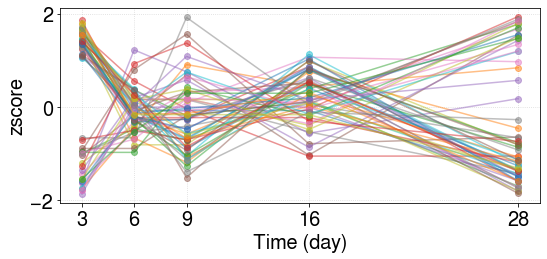

PC1 variance explained: 0.7877605086543277
	 positive data shape: (5, 36)
	 second PCA | PC1 variance explained: 0.857746454414031
	 second PCA | negative loading indices []


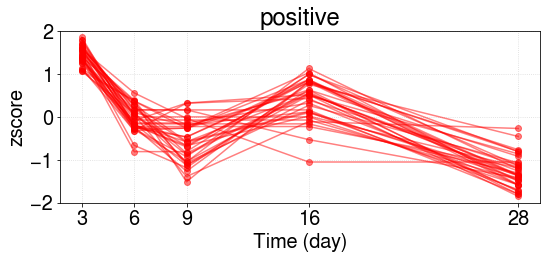

	 negative data shape: (5, 23)
	 second PCA | PC1 variance explained: 0.7060939416582867
	 second PCA | negative loading indices []


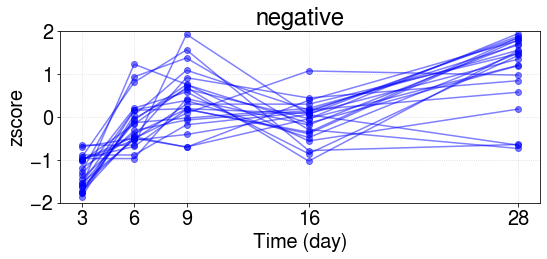

E2F8 186
['NECTIN1', 'PDE1A', 'UHRF1', 'EXO1', 'SPC25', 'RRM2', 'BLM', 'PASK', 'WDR62', 'CDKN1A', 'CDC20', 'CCNB2', 'SHCBP1', 'BUB1B', 'ABCA13', 'IQGAP3', 'TRIP13', 'RACGAP1', 'KIF2C', 'ARHGAP11B', 'VRK1', 'KIF15', 'ORC6', 'TTK', 'DBF4', 'CHAF1A', 'AURKB', 'SKA3', 'SAPCD2', 'DTL', 'PBK', 'FAM83D', 'KNL1', 'CCNB1', 'CDKN3', 'MFGE8', 'TCF19', 'KIF20A', 'KIF18B', 'TROAP', 'GINS1', 'KIFC1', 'AURKA', 'MCM2', 'BUB1', 'NOG', 'CCNF', 'CHAF1B', 'E2F1', 'MCM10', 'ARHGAP11A', 'LMNB1', 'FERMT1', 'ESPL1', 'HMMR', 'CSTA', 'RRM1', 'PLAC8', 'PLK4', 'GALNT6', 'MAD2L1', 'RAD51AP1', 'GINS4', 'PRIM1', 'PIF1', 'DEPDC1B', 'STIL', 'SMC2', 'CDC6', 'SPAG5', 'NCAPG2', 'CDCP1', 'GTSE1', 'CDK1', 'DEPDC1', 'INCENP', 'RAB27B', 'DLGAP5', 'CENPK', 'CEP55', 'MLPH', 'RAD54L', 'TPM3', 'SGO1', 'CDC45', 'MTFR2', 'PDGFRA', 'HMGA1', 'BIRC5', 'ORC1', 'CENPM', 'FIGNL1', 'MELK', 'ESCO2', 'CIT', 'KIF23', 'GINS2', 'TK1', 'FANCA', 'SGO2', 'MCM5', 'PLXDC2', 'ZNF367', 'ZWINT', 'POLQ', 'CKS2', 'SLC12A8', 'PAQR4', 'FAM111B', 'PTTG1',

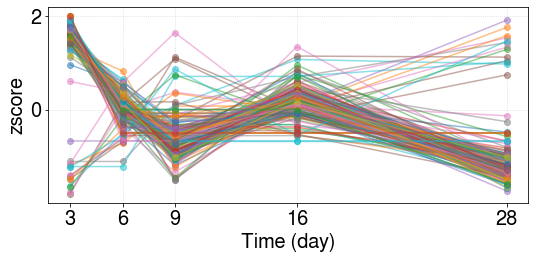

PC1 variance explained: 0.9118708748296744
	 positive data shape: (5, 172)
	 second PCA | PC1 variance explained: 0.9286835719613754
	 second PCA | negative loading indices []


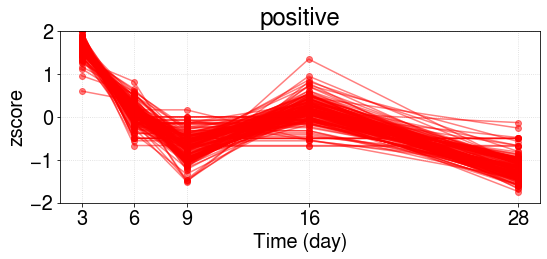

	 negative data shape: (5, 14)
	 second PCA | PC1 variance explained: 0.7782740165140134
	 second PCA | negative loading indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


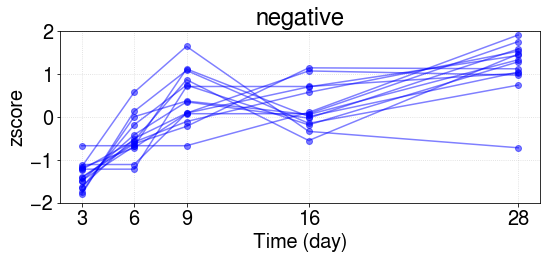

ZNF750 47
['NECTIN1', 'DOCK10', 'ST3GAL5', 'MCC', 'NRCAM', 'MYO1B', 'MME', 'UBASH3B', 'SYNJ2', 'LINC00598', 'ABCA13', 'KCNMA1', 'MYO1D', 'SLC8A1', 'ST6GAL1', 'DAPK2', 'EPAS1', 'FBLN1', 'NFATC2', 'NEDD9', 'PFKP', 'LINC00578', 'TNC', 'PAPPA', 'CRISPLD2', 'TENM2', 'KLF9', 'SLIT3', 'PTK2B', 'HTRA1', 'NTM', 'ZBTB16', 'TIAM1', 'MTSS1', 'LSAMP', 'TGFBR3', 'CD82', 'SLC44A1', 'PTPRF', 'MYLK', 'KIAA1217', 'NABP1', 'MAOA', 'COL21A1', 'CSMD2', 'TPD52L1', 'STIM1']


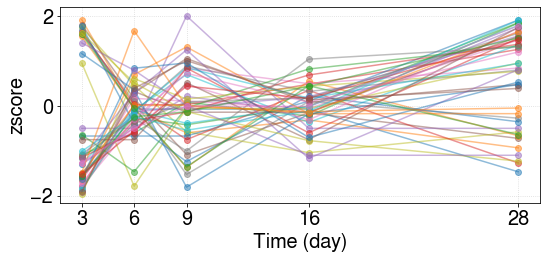

PC1 variance explained: 0.7206015294366773
	 positive data shape: (5, 13)
	 second PCA | PC1 variance explained: 0.7435420627143644
	 second PCA | negative loading indices []


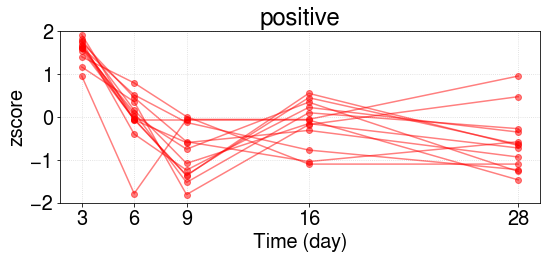

	 negative data shape: (5, 34)
	 second PCA | PC1 variance explained: 0.7457762863215905
	 second PCA | negative loading indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]


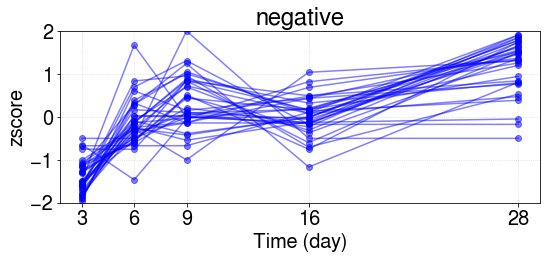

In [19]:
quality = []
for TF, row in df.head(3).iterrows():
    
    number_of_targets = int(row['TF targets DEGs / all TF targets'].split('/')[0])
    print(TF, number_of_targets)

    # plot raw expression of all genes
    targets = row['Observed TF target DEGs'].split(', ')
    print(targets)

    regulon_expression = []
    for target in targets:
        regulon_expression.append(expression_trajectories[target])
    #print(regulon_expression)

    log2_regulon_expression = numpy.log2(regulon_expression)
    #print('log2 reg expression')
    #print(log2_regulon_expression)

    # zscores
    #print('zscores')
    zscores_regulon = scipy.stats.zscore(log2_regulon_expression, axis=1)
    #print(zscores_regulon)
    for gene_trajectory in zscores_regulon: 
        matplotlib.pyplot.plot(time_trajectory, gene_trajectory, 'o-', alpha=0.5)
    matplotlib.pyplot.xlabel('Time (day)')
    matplotlib.pyplot.ylabel('zscore')
    matplotlib.pyplot.xticks(time_trajectory)
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()
       
    ###
    ### exhaustive PCA
    ### 
   
    data = numpy.transpose(zscores_regulon)
    working_targets = targets
       
    # first PCA
    pca = sklearn.decomposition.PCA(n_components=3)
    projection = pca.fit_transform(data)
    PC1_explained_variance = pca.explained_variance_ratio_[0]
    print('PC1 variance explained: {}'.format(PC1_explained_variance))

    PC1_loadings = pca.components_[0]
    positive_loading_indexes = numpy.argwhere(PC1_loadings > 0).flatten()
    negative_loading_indexes = numpy.argwhere(PC1_loadings < 0).flatten()
    
    positive_genes = [working_targets[element] for element in positive_loading_indexes]
    negative_genes = [working_targets[element] for element in negative_loading_indexes]

    # positive case 
    positive_data = data[:, positive_loading_indexes]
    print('\t positive data shape:', positive_data.shape)

    pca = sklearn.decomposition.PCA(n_components=3)
    projection = pca.fit_transform(positive_data)
    PC1_explained_variance = pca.explained_variance_ratio_[0]
    print('\t second PCA | PC1 variance explained: {}'.format(PC1_explained_variance))
    PC1_loadings = pca.components_[0]
    second_PCA_NLI = numpy.argwhere(PC1_loadings < 0).flatten()
    print('\t second PCA | negative loading indices', second_PCA_NLI)
    
    for gene_trajectory in numpy.transpose(positive_data): 
        matplotlib.pyplot.plot(time_trajectory, gene_trajectory, 'o-', alpha=0.5, color='red')
    matplotlib.pyplot.title('positive')
    matplotlib.pyplot.xlabel('Time (day)')
    matplotlib.pyplot.ylabel('zscore')
    matplotlib.pyplot.xticks(time_trajectory)
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    matplotlib.pyplot.ylim([-2, 2])
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()
    
    # negtive case 
    negative_data = data[:, negative_loading_indexes]
    print('\t negative data shape:', negative_data.shape)
    
    pca = sklearn.decomposition.PCA(n_components=3)
    projection = pca.fit_transform(negative_data)
    PC1_explained_variance = pca.explained_variance_ratio_[0]
    print('\t second PCA | PC1 variance explained: {}'.format(PC1_explained_variance))
    PC1_loadings = pca.components_[0]
    second_PCA_NLI = numpy.argwhere(PC1_loadings < 0).flatten()
    print('\t second PCA | negative loading indices', second_PCA_NLI)
    
    for gene_trajectory in numpy.transpose(negative_data): 
        matplotlib.pyplot.plot(time_trajectory, gene_trajectory, 'o-', alpha=0.5, color='blue')
    matplotlib.pyplot.title('negative')
    matplotlib.pyplot.xlabel('Time (day)')
    matplotlib.pyplot.ylabel('zscore')
    matplotlib.pyplot.xticks(time_trajectory)
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    matplotlib.pyplot.ylim([-2, 2])
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

    
              